In [1]:
import os
import sys
sys.path.append('c:/Users/Saroj Chand/Documents/GitHub/nv-center-network-analysis')
from src.utils import extract_nv_data, calculate_distances

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from src.utils import extract_nv_data, calculate_distances
from scripts.data_preprocessing import preprocess_data, save_processed_data
from scripts.network_analysis import compute_correlation_matrix, build_network, plot_network

In [2]:
# Load data from JSON file
file_path = '../data/raw/2024_05_27-04_37_40-johnson-nv0_2024_03_12.txt'
with open(file_path, 'r') as file:
    data = json.load(file)
# Print the keys in the JSON data
print(data.keys())

dict_keys(['nv_list', 'num_steps', 'num_reps', 'num_runs', 'uwave_ind', 'uwave_freq', 'num_exps_per_rep', 'load_iq', 'step_ind_master_list', 'counts-units', 'counts', 'states', 'timestamp', 'config', 'opx_config'])


In [3]:
# Example: Accessing NV List and Keys
nv_list = data['nv_list']
print(f"Number of NVs: {len(nv_list)}")

# Example: Accessing Coordinates of NVs
for nv in nv_list:
    # print(f"NV Name: {nv['name']}")
    print(f"Coordinates (Pixel): {nv['coords']['pixel']}")
    # print(f"Coordinates (Global): {nv['coords']['global']}")

Number of NVs: 10
Coordinates (Pixel): [58.628, 139.616]
Coordinates (Pixel): [137.025, 74.662]
Coordinates (Pixel): [170.501, 132.597]
Coordinates (Pixel): [171.074, 49.877]
Coordinates (Pixel): [173.93, 78.505]
Coordinates (Pixel): [144.169, 163.787]
Coordinates (Pixel): [110.023, 87.942]
Coordinates (Pixel): [135.139, 104.013]
Coordinates (Pixel): [161.477, 105.335]
Coordinates (Pixel): [131.144, 129.272]


In [4]:
# Number of NVs
num_nvs = len(data['nv_list'])
# Extract reference and signal counts
reference_counts = data['counts'][0]
signal_counts = data['counts'][1]

#Make numpy array reference and signal counts
reference_counts = np.array(data['counts'][0])
signal_counts = np.array(data['counts'][1])

# Verify the shape of counts arrays
print(f"Shape of reference_counts: {reference_counts.shape}")
print(f"Shape of signal_counts: {signal_counts.shape}")
# Flatten or reshape the counts data if needed (removing singleton dimension)
reference_counts = np.squeeze(reference_counts)  # This removes singleton dimensions
signal_counts = np.squeeze(signal_counts)
# Verify the shape of counts arrays
print(f"Shape of reference_counts: {reference_counts.shape}")
print(f"Shape of signal_counts: {signal_counts.shape}")

Shape of reference_counts: (10, 2000, 1, 100)
Shape of signal_counts: (10, 2000, 1, 100)
Shape of reference_counts: (10, 2000, 100)
Shape of signal_counts: (10, 2000, 100)


In [5]:
# Average over the repetitions (3rd dimension) to get a (10, 2000) array for each count
avg_reference_counts = np.mean(reference_counts, axis=2)
avg_signal_counts = np.mean(signal_counts, axis=2)
# print(avg_signal_counts)
# Threshold values
threshold_values = np.array([nv['threshold'] for nv in data['nv_list']])
print(threshold_values)
# Apply thresholding to reference and signal counts
binary_reference_counts = np.where(avg_reference_counts > threshold_values[:, None], 1, 0)
binary_signal_counts = np.where(avg_signal_counts > threshold_values[:, None], 1, 0)
# print(binary_signal_counts)

[20.5 22.5 24.5 17.5 22.5 27.5 23.5 25.5 27.5 27.5]


In [6]:
# Function to compute binary counts with thresholding
def apply_thresholding(counts, thresholds):
    return np.where(counts > thresholds[:, None], 1, 0)

# Iteratively adjust threshold values to minimize correlation in reference data
def adjust_thresholds(reference_counts, threshold_values, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
    for iteration in range(max_iterations):
        binary_reference_counts = apply_thresholding(reference_counts, threshold_values)
        correlation_matrix_reference = compute_correlation_matrix(binary_reference_counts)
        avg_correlation = np.mean(np.abs(correlation_matrix_reference[np.triu_indices(num_nvs, k=1)]))

        if avg_correlation < tolerance:
            print(f"Convergence reached at iteration {iteration} with average correlation {avg_correlation}")
            break

        # Adjust thresholds based on correlation matrix
        gradient = np.sum(correlation_matrix_reference, axis=1) - np.diag(correlation_matrix_reference)
        threshold_values -= learning_rate * gradient

    return threshold_values

# Adjust thresholds
adjusted_threshold_values = adjust_thresholds(avg_reference_counts, threshold_values)
print(f"Adjusted threshold values: {adjusted_threshold_values}")


Adjusted threshold values: [17.73739704 18.64312698 21.30665174 14.05344862 19.25787248 26.24163677
 19.3533691  20.68238123 25.06786919 27.15640911]


c:\Users\Saroj Chand\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Saroj Chand\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


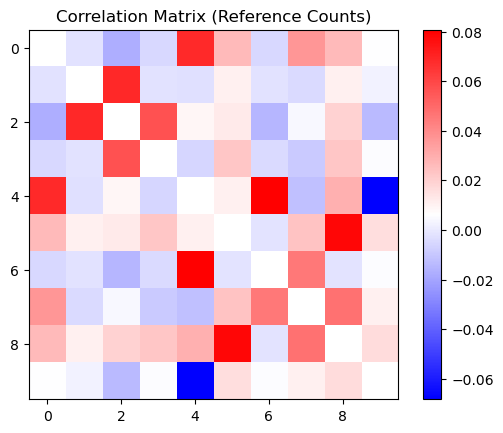

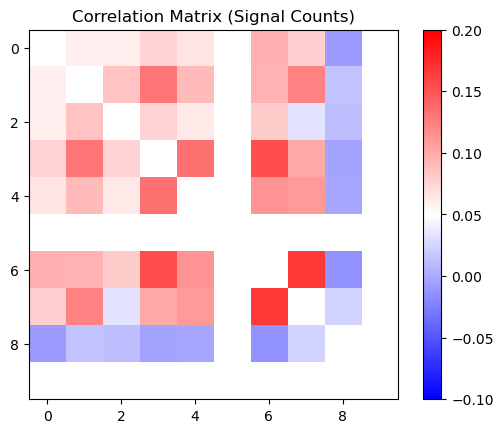

In [93]:

# Apply thresholding to reference and signal counts using adjusted thresholds
binary_reference_counts = apply_thresholding(avg_reference_counts, adjusted_threshold_values)
binary_signal_counts = apply_thresholding(avg_signal_counts, adjusted_threshold_values)


# Compute correlation matrices for shot-to-shot correlations
correlation_matrix_reference = compute_correlation_matrix(binary_reference_counts)
correlation_matrix_signal = compute_correlation_matrix(binary_signal_counts)

# Set the range for the colormap
vmin = -0.1
vmax = 0.2

# Plot correlation matrix for reference counts
# plt.imshow(correlation_matrix_reference, cmap='bwr', interpolation='nearest', vmin=vmin, vmax=vmax)
# Replace diagonal elements with gray color
np.fill_diagonal(correlation_matrix_reference, np.nan)  # Replace diagonal elements with NaN
plt.imshow(correlation_matrix_reference, cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix (Reference Counts)')
plt.show()

# Plot correlation matrix for signal counts
np.fill_diagonal(correlation_matrix_signal,np.nan)
plt.imshow(correlation_matrix_signal, cmap='bwr', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Correlation Matrix (Signal Counts)')
plt.show()

In [88]:
# Save processed data
output_dir = '../data/processed'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_path_reference = os.path.join(output_dir, 'processed_binary_reference_counts.npy')
output_path_signal = os.path.join(output_dir, 'processed_binary_signal_counts.npy')

np.save(output_path_reference, binary_reference_counts)
np.save(output_path_signal, binary_signal_counts)

print(f"Processed binary reference counts saved to: {output_path_reference}")
print(f"Processed binary signal counts saved to: {output_path_signal}")

# Save the correlation matrices
correlation_matrix_path_reference = os.path.join(output_dir, 'correlation_matrix_reference.npy')
correlation_matrix_path_signal = os.path.join(output_dir, 'correlation_matrix_signal.npy')

np.save(correlation_matrix_path_reference, correlation_matrix_reference)
np.save(correlation_matrix_path_signal, correlation_matrix_signal)

print(f"Correlation matrix for reference counts saved to: {correlation_matrix_path_reference}")
print(f"Correlation matrix for signal counts saved to: {correlation_matrix_path_signal}")

Processed binary reference counts saved to: ../data/processed\processed_binary_reference_counts.npy
Processed binary signal counts saved to: ../data/processed\processed_binary_signal_counts.npy
Correlation matrix for reference counts saved to: ../data/processed\correlation_matrix_reference.npy
Correlation matrix for signal counts saved to: ../data/processed\correlation_matrix_signal.npy


In [ ]:
# Compute correlation matrices for shot-to-shot correlations
correlation_matrix_reference = compute_correlation_matrix(binary_reference_counts)
correlation_matrix_signal = compute_correlation_matrix(binary_signal_counts)

# Plot correlation matrices
plt.imshow(correlation_matrix_reference, cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix (Reference Counts)')
plt.show()

plt.imshow(correlation_matrix_signal, cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix (Signal Counts)')
plt.show()


In [ ]:
# Define the output directory
output_dir = '../data/correlation_matrix'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save correlation matrices
np.save(os.path.join(output_dir, 'correlation_matrix_reference.npy'), correlation_matrix_reference)
np.save(os.path.join(output_dir, 'correlation_matrix_signal.npy'), correlation_matrix_signal)

In [ ]:
# Compute correlation matrices
correlation_matrix_reference = np.corrcoef(averaged_reference_counts)
correlation_matrix_signal = np.corrcoef(averaged_signal_counts)

# Plot resized correlation matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

cax0 = axs[0].imshow(correlation_matrix_reference, cmap='hot', interpolation='nearest')
axs[0].set_title('Reference Counts Correlation Matrix')
axs[0].set_xlabel('NVs')
axs[0].set_ylabel('NVs')
fig.colorbar(cax0, ax=axs[0])

cax1 = axs[1].imshow(correlation_matrix_signal, cmap='hot', interpolation='nearest')
axs[1].set_title('Signal Counts Correlation Matrix')
axs[1].set_xlabel('NVs')
axs[1].set_ylabel('NVs')
fig.colorbar(cax1, ax=axs[1])

plt.tight_layout()
plt.show()

In [ ]:
# Threshold values
threshold_values = np.array([nv['threshold'] for nv in data['nv_list']])
# Apply thresholding to reference and signal counts
binary_reference_counts = np.where(averaged_reference_counts > threshold_values[:, None], 1, 0)
binary_signal_counts = np.where(averaged_signal_counts > threshold_values[:, None], 1, 0)
print(binary_reference_counts)
print(binary_reference_counts)

In [ ]:
# Compute correlation matrices
correlation_matrix_reference = np.corrcoef(binary_reference_counts)
correlation_matrix_signal = np.corrcoef(binary_signal_counts)

# Plot resized correlation matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

cax0 = axs[0].imshow(correlation_matrix_reference, cmap='hot', interpolation='nearest')
axs[0].set_title('Reference Counts Correlation Matrix')
axs[0].set_xlabel('NVs')
axs[0].set_ylabel('NVs')
fig.colorbar(cax0, ax=axs[0])

cax1 = axs[1].imshow(correlation_matrix_signal, cmap='hot', interpolation='nearest')
axs[1].set_title('Signal Counts Correlation Matrix')
axs[1].set_xlabel('NVs')
axs[1].set_ylabel('NVs')
fig.colorbar(cax1, ax=axs[1])

plt.tight_layout()
plt.show()

In [ ]:
# Define the output directory
output_dir = '../data/correlation_matrix'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save correlation matrices
np.save(os.path.join(output_dir, 'correlation_matrix_reference.npy'), correlation_matrix_reference)
np.save(os.path.join(output_dir, 'correlation_matrix_signal.npy'), correlation_matrix_signal)